In [ ]:
import numpy as np
class BezierCurve:

    def __init__(self, indices=(0.0, 0.0), control_point0=np.array([0.5, 0.5]), control_point1=np.array([0.5, 0.5])):
        self.indices = indices
        self.control_point0 = control_point0
        self.control_point1 = control_point1
    
    def as_dict(self):
        d = {'indices': self.indices,
             'control_point0': self.control_point0,
             'control_point1': self.control_point1}
    
    @staticmethod
    def load(dict):
        return BezierCurve(dict['indices'], dict['control_point0'], dict['control_point1'])
    
    def __str__(self):
        return "" + str(self.indices[0]) + ":" + str(self.indices[1]) + "#" \
                  + str(self.control_point0.tolist()) + "#" + str(self.control_point1.tolist())

IndentationError: expected an indented block after function definition on line 9 (1652284471.py, line 12)

In [11]:
import os, json
import numpy as np
from trajectory_planner import TrajectoryPlanner

animation_path = r"/home/mwiebe/Documents/Studium/ba/Experiments/happy_alt.txt"
file = open(animation_path, "r")

# read file and compute times and joint goals
times = []
positions = []
beziers = []

# parse 
positions_done = False
for line in file:
    # skip empty lines
    if not line:
        continue

    # check if end of positions was reached
    if line == "CURVES\n":
        positions_done = True
        continue

    parts = line.split("#")
    
    if positions_done:
        # every curve line has the following structure:
        # <index1>:<index2> # <control point 1> # <control point 2>
        if not len(parts) == 3:
            print("WARNING: Line was skipped. (curves)")
            continue

        # read parts
        print(parts)
        curve = BezierCurve(parts[0].split(':'), json.loads(parts[1]), json.loads(parts[2]))
        curve.indices[0] = int(curve.indices[0])
        curve.indices[1] = int(curve.indices[1])
        beziers.append(curve)

    else: 
        # every position line has the following structure:
        # <timestamp> # <joint positions> 
        if not len(parts) == 2:
            print("WARNING: Line was skipped. (positions)")
            continue

        # read parts
        positions.append(json.loads(parts[1]))
        times.append(float(parts[0]))

# apply to trajectory planner
trajectory_planner = TrajectoryPlanner(np.array(times), np.array(positions))

# fill up to make bezier curves possible
original_indices = trajectory_planner.fill_up(20)

# go through beziers and add them to trajectory
for i in range(len(beziers)):
    curve = beziers[i]
    trajectory_planner.apply_bezier_at(original_indices[curve.indices[0]], 
                                        original_indices[curve.indices[1]], 
                                        curve.control_point0, curve.control_point1)

# finally close file
file.close()

positions = np.array(positions)
times = np.array(times)

['0:1', '[0.5, 0.25]', '[0.8, 1.0]\n']
['1:2', '[0.5, 0.4]', '[0.5, 0.6]\n']
['3:7', '[0.5, 0.2]', '[0.8, 0.8]\n']
['7:11', '[0.5, 0.2]', '[0.8, 0.8]\n']
['11:15', '[0.5, 0.2]', '[0.8, 0.8]\n']
['15:16', '[0.5, 0.4]', '[0.5, 0.6]\n']
['18:19', '[0.5, 0.25]', '[0.8, 1.0]\n']


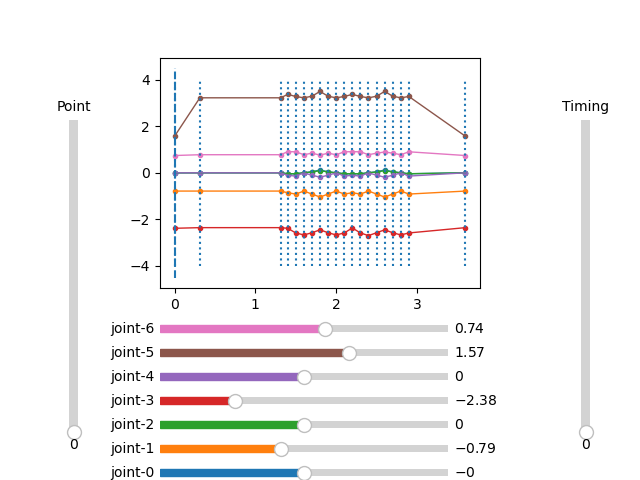

In [12]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider

%matplotlib widget
plt.ion()

# PLOT ANIMATION
fig, ax = plt.subplots()
lines = []
scatters = []
for i in range(len(positions.T)):
    l, = ax.plot(times, positions.T[i], linewidth=1)
    lines.append(l)
    s = ax.scatter(times, positions.T[i], marker=".")
    scatters.append(s)

# JOINT SLIDER UPDATE FUNCTION
def update(val):
    for i in range(len(positions.T)):
        positions[point_slider.val][i] = joint_sliders[i].val
        lines[i].set_ydata(positions.T[i])

# ADD JOINT SLIDERS
joint_sliders = []
for i in range(len(positions.T)):
    axe = fig.add_axes([0.25, 0.05 * i, 0.45, 0.03])
    joint_sliders.append(Slider(ax=axe, label="joint-" + str(i), valmin=-5, valmax = 5, valinit=positions[0][i], color=lines[i].get_color()))
    joint_sliders[i].on_changed(update)

# ADD POINT SLIDER
axe_point = fig.add_axes([0.1, 0.1, 0.03, 0.65])
point_slider = Slider(ax=axe_point, label="Point", valstep=range(len(positions)), valinit=0, valmin=0, valmax=len(positions), orientation='vertical')

# TIMING SLIDER
axe_timing = fig.add_axes([0.9, 0.1, 0.03, 0.65])
timing_slider = Slider(ax=axe_timing, label="Timing", valmin=0.0, valmax=3.0, valinit=0.0, orientation='vertical')
timing_slider.set_active(False)

# ADD VERTICAL LINES
vlines = ax.vlines(times, -4, 4, linestyles="dotted")
indicator = ax.vlines(times[0], -4.5, 4.5, linestyles="dashed")

# UPDATE POINT SLIDER FUNCTION
def update_point(val):
    global indicator
    for i in range(len(positions.T)):
        joint_sliders[i].eventson = False
        joint_sliders[i].set_val(positions[point_slider.val][i])
        #fig.canvas.draw()
        joint_sliders[i].eventson = True
        lines[i].set_ydata(positions.T[i])
    
    # adjust indicator
    indicator.remove()
    indicator = ax.vlines(times[val], -4.5, 4.5, linestyles="dashed")

    # adjust timing slider
    timing_slider.eventson = False
    if val == 0:
        timing_slider.set_val(0)
        timing_slider.set_active(False)
    else:
        timing_slider.set_val(times[val] - times[val-1])
        timing_slider.set_active(True)
    timing_slider.eventson = True

# UPDATE TIMING SLIDER FUNCTION
def update_timing(val):
    global vlines, indicator
    # adjust time value of current point and all following points
    diff = val - (times[point_slider.val] - times[point_slider.val - 1])
    times[point_slider.val:] += diff
    for i in range(len(positions.T)):
        lines[i].set_xdata(times)
        scatters[i].remove()
        scatters[i] = ax.scatter(times, positions.T[i], marker=".")
    
    vlines.remove()
    indicator.remove()
    vlines = ax.vlines(times, -4, 4, linestyles="dotted")
    indicator = ax.vlines(times[point_slider.val], -4.5, 4.5, linestyles="dashed")

point_slider.on_changed(update_point)
timing_slider.on_changed(update_timing)

# SHOW FIGURE
fig.subplots_adjust(left=0.25, bottom=0.4, right=0.75)
plt.show()

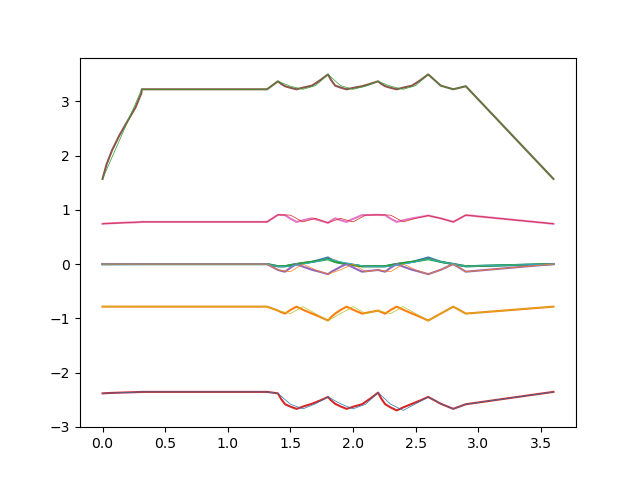

In [13]:
# show WITH béziers

planner = TrajectoryPlanner(times, positions)
# fill up to make bezier curves possible
original_indices = planner.fill_up(20)

import copy
tmp_planner1 = copy.deepcopy(planner)
tmp_planner2 = copy.deepcopy(planner)


# go through beziers and add them to trajectory
for i in range(len(beziers) - 1):
    curve = beziers[i]
    tmp_planner1.apply_bezier_at(original_indices[curve.indices[0]], 
                                    original_indices[curve.indices[1]], 
                                    curve.control_point0, curve.control_point1)

plt.figure()
plt.plot(tmp_planner1.times, tmp_planner1.positions)
plt.plot(tmp_planner2.times, tmp_planner2.positions, linewidth=0.5)
plt.show()

In [14]:

def split_bezier(cp1, cp2, t):
    """
    Split a bézier curve with points [0,0], <cp0>, <cp1>, [1,1]
    into sub-curves at time <t> (normalized to 0 - 1).
    Returns cp0, cp1 for first curve, split point, and cp0, cp1 for second curve
    """
    cp0 = np.array([0,0])
    cp3 = np.array([1,1])

    m0 = cp0 + (cp1 - cp0) * t
    m1 = cp1 + (cp2 - cp1) * t
    m2 = cp2 + (cp3 - cp2) * t

    q0 = m0 + (m1 - m0) * t
    q1 = m1 + (m2 - m1) * t

    p = q0 + (q1 - q0) * t

    #return (m0 * 1/p, q0 * 1/p, p, (m2 - p) * 1/(p+1), (q1 - p) * 1/(p+1))
    scale = 1/(1 - p)
    return (m0 / p, 
            q0 / p, 
            p, 
            (q1 - p) * scale, 
            (m2 - p) * scale)


0.5263157894736842 [0.52631579 0.52631579] [0.51975507 0.67721242]
[0.50631136 0.38858988] [0.74614306 0.73627557]
[0.24726776 0.49796748] [0.5068306  0.85325203]


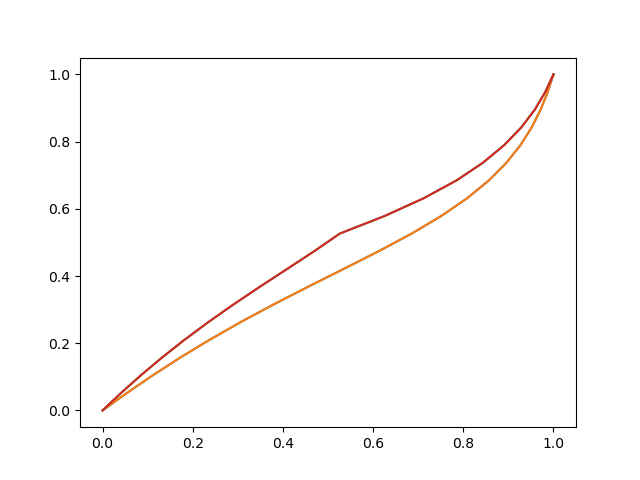

In [15]:
import copy
testplan = TrajectoryPlanner(np.linspace(0.0, 1.0, 20), np.linspace([0.0, 0.0], [1.0, 1.0], 20))
testplan2 = copy.deepcopy(testplan)

g_cp0 = np.array([0.5, 0.5])
g_cp1 = np.array([0.5, 0.9])

testplan.apply_bezier_at(0, 19, g_cp0, g_cp1)

plt.figure()
plt.plot(testplan.times, testplan.positions)

a_cp0, a_cp1, p, b_cp0, b_cp1 = split_bezier(g_cp0, g_cp1, testplan2.times[10])
print(testplan2.times[10], testplan2.positions[10], p)

print(a_cp0, a_cp1)
print(b_cp0, b_cp1)

testplan2.apply_bezier_at(0, 10, a_cp0, a_cp1)
testplan2.apply_bezier_at(10, 19, b_cp0, b_cp1)

plt.plot(testplan2.times, testplan2.positions)
plt.show()

In [ ]:
"""
Save as YAML
"""
from yaml import load, dump
from std_msgs.msg import Duration
from trajectory_msgs.msg import JointTrajectory, JointTrajectoryPoint

try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

# convert to dict
data = {}
data['header'] = {'animation_name': 'happy_test'}

trajectory = JointTrajectory(joint_names=[  "panda_finger_joint1",
                                    "panda_finger_joint2",
                                    "panda_joint1",
                                    "panda_joint2",
                                    "panda_joint3",
                                    "panda_joint4",
                                    "panda_joint5",
                                    "panda_joint6",
                                    "panda_joint7"])
trajectory.header.frame_id = "panda_joint0"

points = []

for i in range(len(positions)):
    point = JointTrajectoryPoint()
    point.time_from_start = Duration(times[i])
    point.positions = positions[i]
    points.append(point)

trajectory.points = points

data['trajectory'] = load(str(trajectory), Loader)

# beziers


print(dump(data))

header:
  animation_name: happy_test
trajectory:
  header:
    frame_id: panda_joint0
    seq: 0
    stamp:
      nsecs: 0
      secs: 0
  joint_names:
  - panda_finger_joint1
  - panda_finger_joint2
  - panda_joint1
  - panda_joint2
  - panda_joint3
  - panda_joint4
  - panda_joint5
  - panda_joint6
  - panda_joint7
  points:
  - accelerations: []
    effort: []
    positions:
    - -0.00334918 -0.7851      0.         -2.3844713   0.          1.5699 0.7424
    time_from_start:
      data: 0.0
    velocities: []
  - accelerations: []
    effort: []
    positions:
    - 0.     -0.785   0.     -2.3565  0.      3.2225  0.7771
    time_from_start:
      data: 0.31334841628959276
    velocities: []
  - accelerations: []
    effort: []
    positions:
    - 0.     -0.785   0.     -2.3565  0.      3.2225  0.7771
    time_from_start:
      data: 1.3133484162895934
    velocities: []
  - accelerations: []
    effort: []
    positions:
    - -0.0406    -0.8575    -0.0406    -2.3844713 -0.1081    